#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X: List[List[float]], y: List[int], w: List[float], w0: float, gamma=1., beta=1.) -> float:
    """
    Вычисляет значение функции потерь логистической регрессии.

    Args:
        X: Список списков, представляющих признаки. Каждая вложенный список - это один образец.
        y: Список целых чисел, представляющих метки классов (1 или -1).
        w: Список чисел, представляющих веса модели.
        w0: Число, представляющее сдвиг (bias) модели.
        gamma: Коэффициент регуляризации L1.
        beta: Коэффициент регуляризации L2.

    Returns:
        Значение функции потерь.
    """
    # Преобразование входных данных в numpy массивы для удобства вычислений
    X_np, y_np, w_np = np.array(X), np.array(y), np.array(w)

    # Вычисление линейной комбинации признаков и весов
    linear_combination = X_np.dot(w_np) + w0

    # Вычисление члена логистической регрессии
    # ln(1 + exp(-y_i * (w^T * x_i + w0)))
    log_loss_term = np.mean(np.log(1 + np.exp(-y_np * linear_combination)))

    # Вычисление члена регуляризации L1
    l1_regularization = gamma * np.sum(np.abs(w_np))

    # Вычисление члена регуляризации L2
    l2_regularization = beta * np.sum(w_np**2)

    # Суммирование всех членов для получения общего значения функции потерь
    total_loss = log_loss_term + l1_regularization + l2_regularization

    return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    N = X.shape[0]
    # Вычисление сигмоиды
    sigmoid = 1 / (1 + np.exp(y * (X.dot(w) + w0)))
    # Вычисление градиентов функции потерь логистической регрессии
    grad_w = -(1 / N) * X.T.dot(y * sigmoid) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -(1 / N) * np.sum(y * sigmoid)
    return grad_w, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    """
    Модель логистической регрессии с L1 и L2 регуляризацией.
    """
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        """
        Инициализация гиперпараметров модели.

        Args:
            beta (float): Коэффициент L2 регуляризации.
            gamma (float): Коэффициент L1 регуляризации.
            lr (float): Скорость обучения (learning rate) для градиентного спуска.
            tolerance (float): Порог для остановки градиентного спуска (изменение потерь).
            max_iter (int): Максимальное количество итераций градиентного спуска.
            random_state (int): Зерно для генератора случайных чисел (для инициализации весов).
        """
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None      # Веса модели
        self.w0 = None     # Смещение модели
        self.classes_ = None # Метки классов (например, [-1, 1])
        self.n_features_in_ = None # Количество признаков в обучающей выборке

    def fit(self, X, y):
        """
        Обучение модели логистической регрессии методом градиентного спуска.

        Args:
            X (array-like, shape (n_samples, n_features)): Тренировочные данные.
            y (array-like, shape (n_samples,)): Целевые метки.
        """
        # Преобразование входных данных в numpy массивы
        X_np = np.asarray(X)
        y_np = np.asarray(y)

        self.n_features_in_ = X_np.shape[1]

        # Определение уникальных классов и их преобразование в {-1, 1}
        unique_classes = np.unique(y_np)

        # Создаем маппинг для классов, чтобы работать с {-1, 1}
        sorted_classes = sorted(unique_classes)
        self.classes_ = np.array(sorted_classes) # Сохраняем оригинальные метки
        class_map = {sorted_classes[0]: -1, sorted_classes[1]: 1}
        y_transformed = np.array([class_map[label] for label in y_np])

        # Инициализация весов и смещения
        np.random.seed(self.random_state)
        # Инициализация весов с помощью нормального распределения
        self.w = np.random.randn(self.n_features_in_) * 0.01
        self.w0 = np.random.randn() * 0.01 # Смещение

        prev_loss = float('inf')
        self.loss_history = []

        # Градиентный спуск
        for i in range(self.max_iter):
            # Вычисление градиентов
            grad_w, grad_w0 = get_grad(X_np, y_transformed, self.w, self.w0, self.gamma, self.beta)

            # Обновление весов и смещения
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            # Вычисление текущих потерь для проверки сходимости
            current_loss = loss(X_np, y_transformed, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            # Проверка на сходимость
            if abs(prev_loss - current_loss) < self.tolerance:
                print(f"Сходимость достигнута на итерации {i+1}")
                break
            prev_loss = current_loss

        return self

    def predict_proba(self, X):
        """
        Оценка вероятностей принадлежности к положительному классу.

        Args:
            X (array-like, shape (n_samples, n_features)): Данные для предсказания.

        Returns:
            np.ndarray, shape (n_samples, 2): Массив вероятностей для каждого класса.
                                             Первый столбец - для отрицательного класса,
                                             второй - для положительного.
        """

        X_np = np.asarray(X)

        # Вычисление линейной комбинации
        z = X_np.dot(self.w) + self.w0

        # Вычисление вероятности положительного класса (класс 1)
        # P(y=1 | x) = sigmoid(z) = 1 / (1 + exp(-z))
        with np.errstate(under='ignore', over='ignore'):
             prob_positive_class = 1 / (1 + np.exp(-np.clip(z, -500, 500)))

        # Вероятность отрицательного класса (класс -1, который мы сопоставили с 0)
        prob_negative_class = 1 - prob_positive_class

        # Возвращаем вероятности в формате Scikit-learn: [prob_class_0, prob_class_1]
        return np.vstack((prob_negative_class, prob_positive_class)).T

    def predict(self, X):
        """
        Предсказание меток классов для каждого объекта из X.

        Args:
            X (array-like, shape (n_samples, n_features)): Данные для предсказания.

        Returns:
            np.ndarray, shape (n_samples,): Вектор предсказанных меток классов.
        """

        X_np = np.asarray(X)

        # Вычисление линейной комбинации
        z = X_np.dot(self.w) + self.w0

        # Применение порога 0 для предсказания класса { -1, 1 }
        # Если z >= 0, предсказываем класс 1 (положительный)
        # Если z < 0, предсказываем класс -1 (отрицательный)
        predicted_labels_transformed = np.where(z >= 0, 1, -1)

        # Преобразование обратно в оригинальные метки классов
        predicted_labels = np.array([self.classes_[1] if label == 1 else self.classes_[0] for label in predicted_labels_transformed])

        return predicted_labels

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y):
    """
    Отрисовывает объекты датасета, их метки и разделяющую гиперплоскость.

    Args:
        model: Обученная модель логистической регрессии (должна иметь методы predict и predict_proba).
        X (np.ndarray): Массив признаков датасета.
        y (np.ndarray): Массив меток датасета (должен содержать -1 и 1).
    """
    y_plot = np.copy(y) # Используем копию, чтобы не изменять исходный y

    plt.figure(figsize=(8, 6))

    # Отрисовка точек данных
    # Убедимся, что y_plot корректно используется для разделения
    if np.any(y_plot == 1) and np.any(y_plot == -1):
        plt.scatter(X[:, 0][y_plot == 1], X[:, 1][y_plot == 1], marker='o', color='blue', label='Класс 1')
        plt.scatter(X[:, 0][y_plot == -1], X[:, 1][y_plot == -1], marker='x', color='red', label='Класс -1')
    elif np.any(y_plot == 1):
        plt.scatter(X[:, 0][y_plot == 1], X[:, 1][y_plot == 1], marker='o', color='blue', label='Класс 1')
    elif np.any(y_plot == -1):
        plt.scatter(X[:, 0][y_plot == -1], X[:, 1][y_plot == -1], marker='x', color='red', label='Класс -1')
    else:
        print("Нет данных для отрисовки классов.")

    # Определение диапазона для отрисовки гиперплоскости
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Предсказание для каждой точки сетки
    # Используем predict, который возвращает метки {-1, 1}
    grid_predictions = model.predict(np.c_[xx.ravel(), yy.ravel()])
    grid_predictions = grid_predictions.reshape(xx.shape)

    # Получим вероятности для класса 1 на сетке
    grid_proba_class_1 = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    grid_proba_class_1 = grid_proba_class_1.reshape(xx.shape)

    # Отрисовываем области с помощью contourf, используя вероятности
    plt.contourf(xx, yy, grid_proba_class_1, cmap=plt.cm.coolwarm, alpha=0.3)
    # Добавим линию, где вероятность 0.5 (собственно граница)
    plt.contour(xx, yy, grid_proba_class_1, levels=[0.5], colors='black', linewidths=2)


    plt.title('Граница принятия решений Логистической Регрессии')
    plt.legend()
    plt.grid(True)
    plt.show()

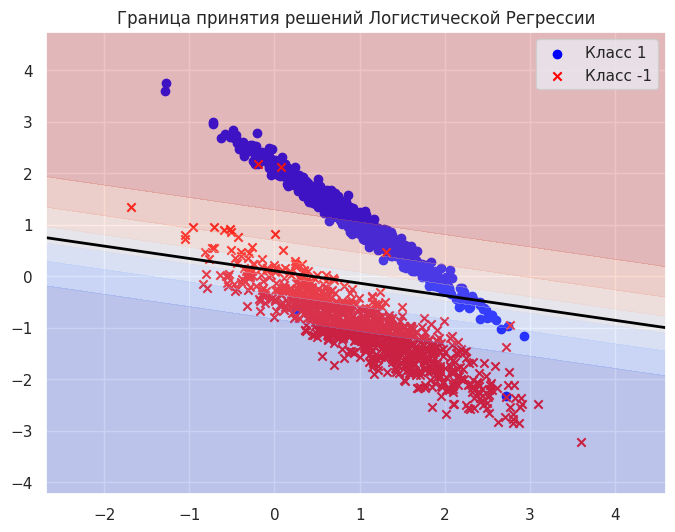

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    """
    Строит график изменения функции потерь в процессе обучения модели.

    Args:
        model (Logit): Обученная модель Logit.
    """
    # Ради постройки этого графика в класс был добавлен список loss_history,
    # который хранит значение фугкции потерь при каждрй итерации
    loss_history = model.loss_history
    plt.plot(range(1, len(loss_history) + 1), loss_history)
    plt.xlabel("Итерация")
    plt.ylabel("Функция потерь")
    plt.title("Изменение функции потерь в процессе обучения")
    plt.grid(True)
    plt.show()

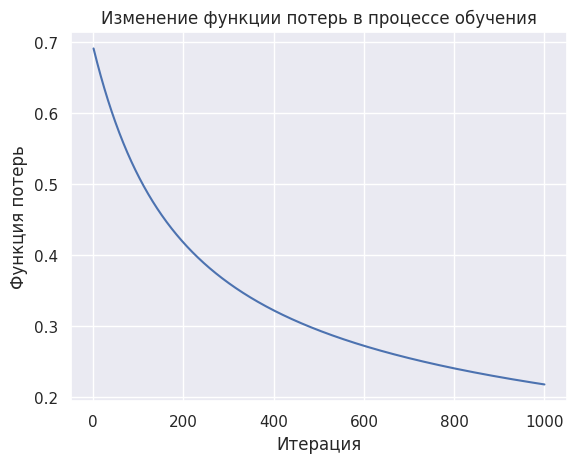

In [11]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import numpy as np

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определим различные ядра и значения C для тестирования
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
c_values = [0.1, 1, 10, 100]

# Словарь для хранения результатов
results = {}

# Проведем эксперименты
for kernel in kernels:
    for c in c_values:
        # Создадим и обучим модель SVC
        svc = SVC(kernel=kernel, C=c, random_state=42, probability=True) # probability=True для AUC-ROC
        svc.fit(X_train, y_train)

        # Сделаем предсказания на тестовой выборке
        y_pred = svc.predict(X_test)
        y_prob = svc.predict_proba(X_test)[:, 1] # Вероятности для класса 1

        # Рассчитаем метрики
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)

        # Сохраним результаты
        key = f"kernel='{kernel}', C={c}"
        results[key] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'AUC-ROC': roc_auc,
            'F1-Score': f1
        }

# Выведем результаты
print("Результаты экспериментов с SVC:")
for key, metrics in results.items():
    print(f"\n--- {key} ---")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

Результаты экспериментов с SVC:

--- kernel='linear', C=0.1 ---
Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
AUC-ROC: 0.9986
F1-Score: 0.9943

--- kernel='linear', C=1 ---
Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
AUC-ROC: 0.9989
F1-Score: 0.9943

--- kernel='linear', C=10 ---
Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
AUC-ROC: 0.9990
F1-Score: 0.9943

--- kernel='linear', C=100 ---
Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
AUC-ROC: 0.9987
F1-Score: 0.9943

--- kernel='poly', C=0.1 ---
Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
AUC-ROC: 0.9938
F1-Score: 0.9943

--- kernel='poly', C=1 ---
Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
AUC-ROC: 0.9946
F1-Score: 0.9943

--- kernel='poly', C=10 ---
Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
AUC-ROC: 0.9940
F1-Score: 0.9943

--- kernel='poly', C=100 ---
Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
AUC-ROC: 0.9945
F1-Score: 0.9943

--- kernel='rbf', C=0.1 ---
Accuracy: 0.9944
Precision: 0.992

#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [ ]:
class HingeLossClassifier:
    def __init__(self, learning_rate=0.01, num_iterations=1000, lambda_reg=0.01):
        """
        Конструктор для HingeLossClassifier.

        Args:
            learning_rate (float): Скорость обучения.
            num_iterations (int): Количество итераций обучения.
            lambda_reg (float): Коэффициент регуляризации.
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.lambda_reg = lambda_reg
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Обучает линейный классификатор с использованием Hinge loss.

        Args:
            X (np.ndarray): Массив признаков обучающей выборки (n_samples, n_features).
            y (np.ndarray): Массив меток обучающей выборки (n_samples,).
        """
        n_samples, n_features = X.shape

        # Инициализация весов и смещения
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Преобразуем метки в формат +1/-1
        y_transformed = np.where(y == 0, -1, 1)

        # Градиентный спуск
        for _ in range(self.num_iterations):
            for idx, x_i in enumerate(X):
                # Вычисляем значение линейной комбинации
                linear_output = np.dot(x_i, self.weights) + self.bias

                # Проверяем условие Hinge loss
                if y_transformed[idx] * linear_output < 1:
                    # Обновляем веса и смещение, используя градиент Hinge loss
                    # Градиент для весов: -y_i * x_i + lambda * w
                    # Градиент для смещения: -y_i
                    self.weights = self.weights - self.learning_rate * (
                        -y_transformed[idx] * x_i + self.lambda_reg * self.weights
                    )
                    self.bias = self.bias - self.learning_rate * (-y_transformed[idx])
                else:
                    # Если условие Hinge loss выполнено, обновляем только с учетом регуляризации
                    self.weights = self.weights - self.learning_rate * (self.lambda_reg * self.weights)

    def predict(self, X):
        """
        Предсказывает метки классов для новых данных.

        Args:
            X (np.ndarray): Массив признаков для предсказания (n_samples, n_features).

        Returns:
            np.ndarray: Массив предсказанных меток классов (0 или 1).
        """
        linear_output = np.dot(X, self.weights) + self.bias
        # Применяем пороговое значение для классификации
        y_predicted = (linear_output >= 0).astype(int)
        return y_predicted

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение классификатора
hinge_classifier = HingeLossClassifier(learning_rate=0.01, num_iterations=2000, lambda_reg=0.01)
hinge_classifier.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = hinge_classifier.predict(X_test)

# 1. Вычисление классификационных метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
# --------------------------

print("--- Классификационные метрики ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from collections import Counter # Для определения класса доминирующего среди ближайших соседей

class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        """
        Инициализация KNN классификатора.

        Args:
            n_neighbors (int): Количество ближайших соседей для рассмотрения.
            metric (str): Метрика расстояния для вычисления расстояний между точками.
                          Поддерживаются 'euclidean' и 'manhattan'.
        """
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None
        self.classes_ = None # Для хранения уникальных классов

    def _calculate_distance(self, x1, x2):
        """
        Вычисляет расстояние между двумя точками на основе заданной метрики.

        Args:
            x1 (np.ndarray): Первая точка.
            x2 (np.ndarray): Вторая точка.

        Returns:
            float: Рассчитанное расстояние.
        """
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2)**2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError(f"Неподдерживаемая метрика: {self.metric}")

    def fit(self, X, y):
        """
        Обучение KNN классификатора (просто сохраняет обучающие данные).

        Args:
            X (np.ndarray): Обучающие признаки.
            y (np.ndarray): Обучающие метки классов.
        """
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.classes_ = np.unique(y) # Сохраняем уникальные классы

    def predict(self, X):
        """
        Предсказание меток классов для новых данных.

        Args:
            X (np.ndarray): Признаки для предсказания.

        Returns:
            np.ndarray: Предсказанные метки классов.
        """
        predictions = []
        X_input = np.array(X) # Убедимся, что X - numpy массив

        for x in X_input:
            # Вычисляем расстояния до всех обучающих точек
            distances = [self._calculate_distance(x, x_train) for x_train in self.X_train]
            # Получаем индексы k ближайших соседей
            k_indices = np.argsort(distances)[:self.n_neighbors]
            # Получаем метки классов k ближайших соседей
            k_nearest_labels = self.y_train[k_indices]
            # Определяем наиболее частый класс среди соседей
            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])
        return np.array(predictions)

    def predict_proba(self, X):
        """
        Выдача вектора вероятностей принадлежности к каждому классу.

        Args:
            X (np.ndarray): Признаки для предсказания.

        Returns:
            np.ndarray: Матрица вероятностей, где каждая строка соответствует объекту,
                        а каждый столбец - вероятности принадлежности к соответствующему классу.
        """
        probabilities = []
        X_input = np.array(X) # Убедимся, что X - numpy массив
        num_classes = len(self.classes_) # Получаем количество классов из fit

        for x in X_input:
            # Вычисляем расстояния до всех обучающих точек
            distances = [self._calculate_distance(x, x_train) for x_train in self.X_train]
            # Получаем индексы k ближайших соседей
            k_indices = np.argsort(distances)[:self.n_neighbors]
            # Получаем метки классов k ближайших соседей
            k_nearest_labels = self.y_train[k_indices]

            # Подсчитываем количество соседей каждого класса
            class_counts = Counter(k_nearest_labels)
            total_neighbors = len(k_nearest_labels)

            # Формируем вектор вероятностей
            proba = np.zeros(num_classes)
            for class_label, count in class_counts.items():
                proba[class_label] = count / total_neighbors
            probabilities.append(proba)
        return np.array(probabilities)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создание и обучение классификатора KNN
knn_model = KNNClassifier(n_neighbors=5, metric='euclidean')
knn_model.fit(X_train, y_train)

# Предсказание меток классов
y_pred = knn_model.predict(X_test)

# Получение вероятностей классов
y_proba = knn_model.predict_proba(X_test)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test, y_pred)

# Вывод метрик
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.9944
Precision: 0.9945
Recall: 0.9944
AUC-ROC: 0.9945
F1-Score: 0.9944


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
df = pd.read_csv('fashion-mnist.csv')
train_df = df.iloc[:50000]
test_df = df.iloc[50000:]
print("\nПервые 5 строк обучающей выборки (Train):")
print(train_df.head())
print("\nПервые 5 строк тестовой выборки (Test):")
print(test_df.head())


Первые 5 строк обучающей выборки (Train):
  label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixe

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

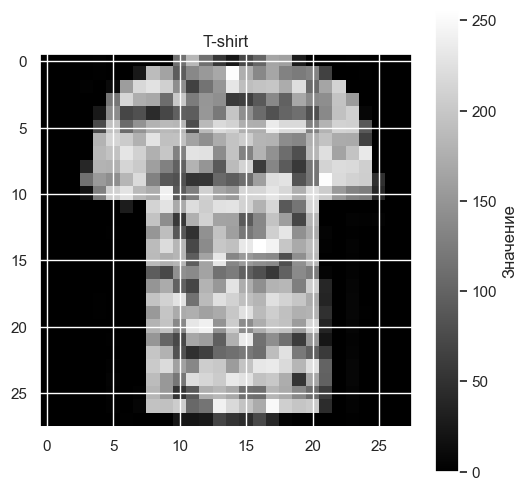

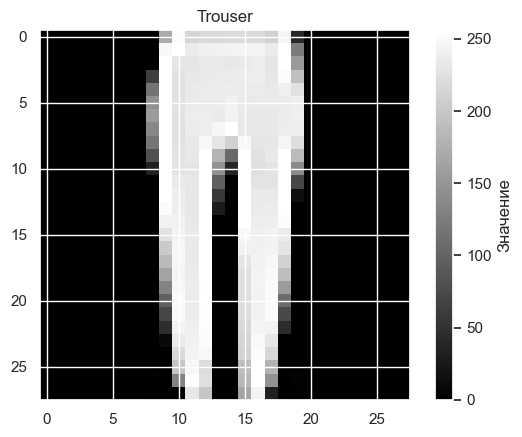

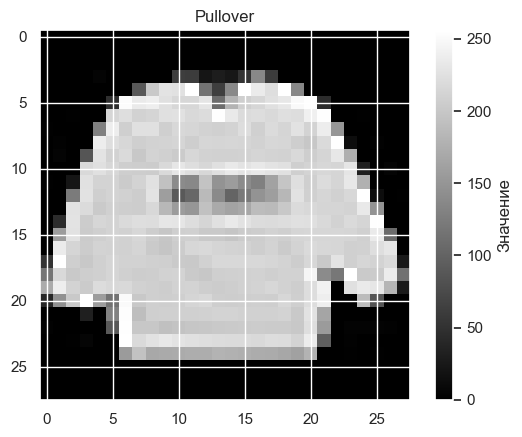

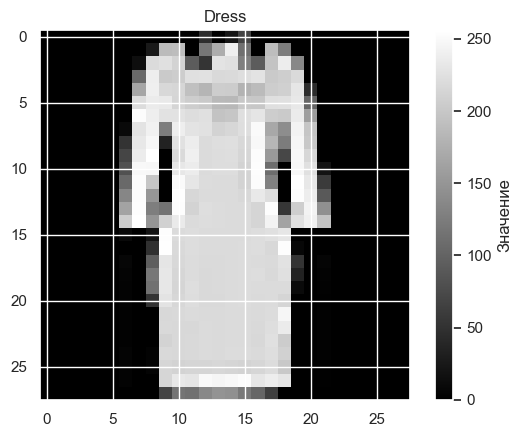

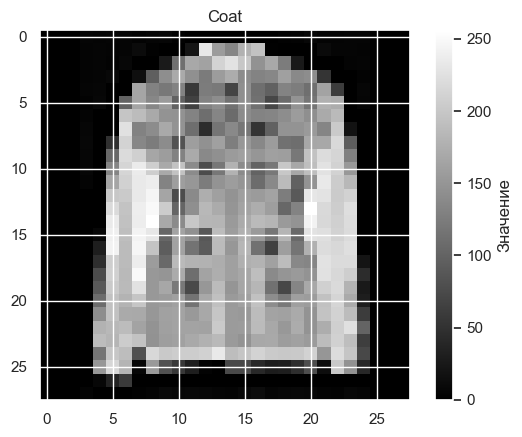

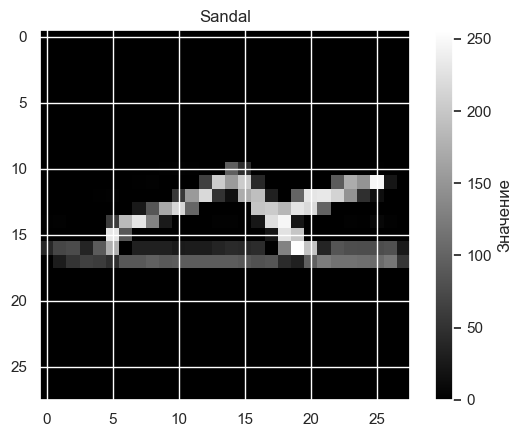

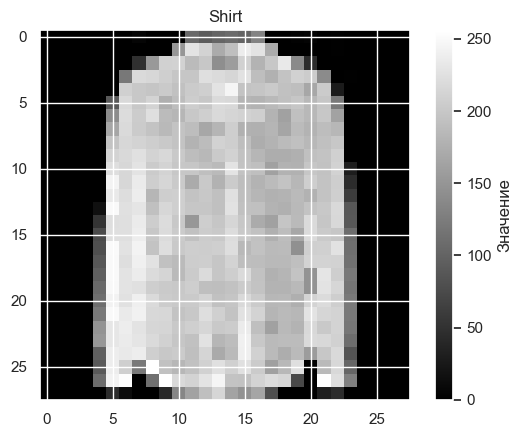

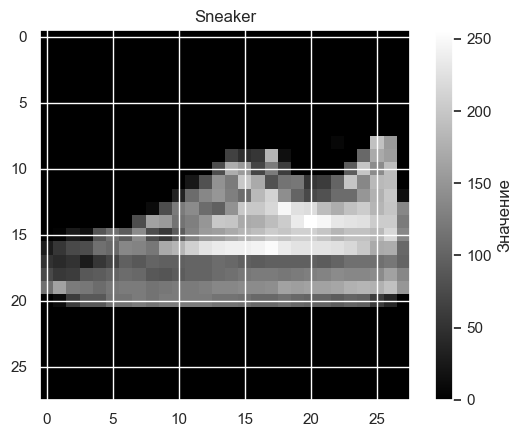

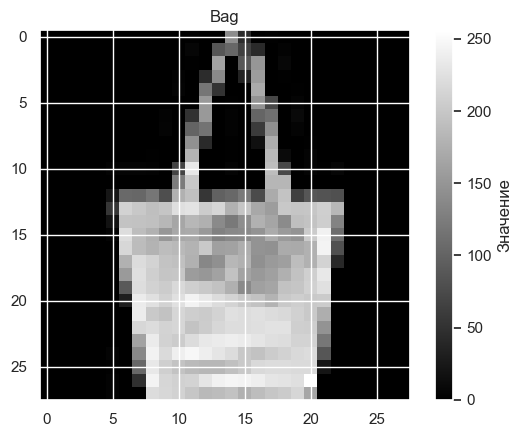

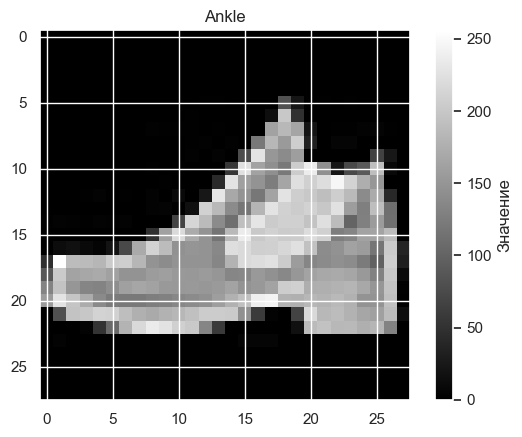

In [ ]:
def string_to_matrix(data_string):
    # Разделяем строку на отдельные числа
    numbers_str = data_string.split(',')

    # Проверяем, что количество чисел равно 28 * 28 = 784
    if len(numbers_str) != 28 * 28:
        print(f"Ошибка: Ожидалось 784 числа, но получено {len(numbers_str)}.")
        return None
    numbers = [int(num) for num in numbers_str]  # Используем float для большей гибкости

    # Создаем матрицу 28x28
    matrix = []
    for i in range(28):
        row = numbers[i * 28 : (i + 1) * 28]
        matrix.append(row)

    return matrix

classes = [[] for i in range(10)]
number = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
i = 0
k = 0
while k != 10:
    class_i = int(df.iloc[i, 0][0])
    if class_i in number:
        if classes[class_i] == []:
            classes[class_i] = string_to_matrix(df.iloc[i, 0][2:])
            k += 1
    i += 1

title = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle']

plt.figure(figsize=(6, 6)) # Создаем фигуру с заданным размером (опционально)

# Используем 'imshow' для отображения матрицы как изображения.
# 'cmap' определяет цветовую карту. 'gray' - для градиентов серого.
# 'vmin' и 'vmax' устанавливают диапазон для цветовой карты.
for i in range(10):
    plt.imshow(classes[i], cmap='gray', vmin=0, vmax=256)
    plt.title(title[i])
    plt.colorbar(label='Значение')
    plt.show()


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
import csv

header = []
df_new = []
with open('fashion-mnist.csv', 'r', newline='', encoding='utf-8') as csvfile:
            csv_reader = csv.reader(csvfile)
            header =(''.join(next(csv_reader))).split(',')
            for row in csv_reader:
                df_new.append(''.join(row).split(','))
numerical_features = header[1:]
df_new = pd.DataFrame(df_new, columns=header)
print(df_new.head())
train_new = df_new.iloc[:50000]
test_new = df_new.iloc[50000:]

  label pixel1 pixel2 pixel3 pixel4 pixel5 pixel6 pixel7 pixel8 pixel9  ...  \
0     2      0      0      0      0      0      0      0      0      0  ...   
1     9      0      0      0      0      0      0      0      0      0  ...   
2     6      0      0      0      0      0      0      0      5      0  ...   
3     0      0      0      0      1      2      0      0      0      0  ...   
4     3      0      0      0      0      0      0      0      0      0  ...   

  pixel775 pixel776 pixel777 pixel778 pixel779 pixel780 pixel781 pixel782  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0       30       43        0        0        0   
3        3        0        0        0        0        1        0        0   
4        0        0        0        0        0        0        0        0   

  pixel783 pixel784  
0        0        0  
1        0        

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Создание экземпляра StandardScaler
scaler_standard = StandardScaler()

scaler_minmax = MinMaxScaler()

# Обучение и трансформация данных
standard_df_new_train = scaler_standard.fit_transform(train_new[numerical_features])
standard_df_new_test = scaler_standard.transform(test_new[numerical_features])

minmax_df_new_train = scaler_minmax.fit_transform(train_new[numerical_features])
minmax_df_new_test = scaler_minmax.transform(test_new[numerical_features])

X_train1, y_train1 = standard_df_new_train, train_new['label']
X_test1, y_test1 = standard_df_new_test, test_new['label']

X_train2, y_train2 = minmax_df_new_train, train_new['label']
X_test2, y_test2 = minmax_df_new_test, test_new['label']

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

Описание к коду:
    Для модели K-ближайших соседей (KNeighborsClassifier), параметры в param_grid_knn были выбраны с целью исследования ключевых аспектов её поведения. n_neighbors — это основной гиперпараметр, определяющий, сколько соседей будет учитываться при классификации. Диапазон от 3 до 20 охватывает как более “локальные” (малое n_neighbors), так и более “глобальные” (большое n_neighbors) решения, позволяя модели находить баланс между чувствительностью к локальным особенностям данных и устойчивостью к шуму. Параметр weights позволяет оценить, влияет ли расстояние до каждого соседа одинаково ('uniform') или более близкие соседи должны иметь больший вес ('distance'), что может быть важно для задач, где близость имеет явное значение. Наконец, metric определяет, как измеряется расстояние между точками. Выбор между 'euclidean' (евклидово расстояние, стандартное “прямое” расстояние) и 'manhattan' (расстояние городских кварталов, сумма абсолютных разностей координат) позволяет учесть, может ли геометрия данных лучше описываться одной метрикой, чем другой, что особенно актуально для данных с разной масштабированностью признаков.
    В сетке гиперпараметров для логистической регрессии (param_grid_lr_refined) основное внимание уделено регулированию сложности модели и выбору оптимального решающего алгоритма. Параметр C (обратная сила регуляризации) варьируется в широком диапазоне от 0.001 до 100. Малые значения C соответствуют сильной регуляризации, предотвращая переобучение, в то время как большие значения C позволяют модели быть более гибкой. Этот диапазон необходим для поиска оптимального баланса между смещенностью и дисперсией. Выбор solver включает 'liblinear' и 'saga'. 'liblinear' является хорошим выбором для небольших и средних наборов данных и поддерживает как L1, так и L2 регуляризацию. 'saga' — более современный решатель, который также эффективен для больших наборов данных и поддерживает оба типа регуляризации ('l1' и 'l2'), позволяя исследовать более масштабируемые сценарии (также 'lbfgs', 'newton-cg', 'sag' не были выбраны из-за возможных конфликтов в коде, ведь например 'lbfgs' не работает при penalty 'l1'. Параметр penalty ('l1' и 'l2') явно включает оба наиболее распространенных типа регуляризации: L1 (Lasso) способствует отбору признаков, а L2 (Ridge) уменьшает величину весов, предотвращая чрезмерное влияние отдельных признаков.
    После запуска кода видно, что обе модели имеют одинаковые значения accuracy, что можно обьяснить тем, что из-за того, что был применен GridSearchCV, обе модели, были оптимально настроенны для своих архитектур, вышли на один и тот же предел производительности, который диктуется качеством самих данных.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Определение сетки гиперпараметров для KNeighborsClassifier
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Создание экземпляра KNeighborsClassifier
knn = KNeighborsClassifier()

# Создание экземпляра GridSearchCV (минимум 5 фолдов)
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение GridSearchCV на тренировочных данных
grid_search_knn.fit(X_train, y_train)

# Лучшие гиперпараметры и качество
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print("--- KNeighborsClassifier ---")
print(f"Лучшие гиперпараметры: {best_params_knn}")
print(f"Среднее качество на кросс-валидации: {best_score_knn:.4f}")


# Создадим сетку:
param_grid_lr_refined = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

# Создание экземпляра LogisticRegression
lr = LogisticRegression(max_iter=1000) # Увеличим max_iter на случай несходимости

# Создание экземпляра GridSearchCV (минимум 5 фолдов)
grid_search_lr = GridSearchCV(lr, param_grid_lr_refined, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение GridSearchCV на тренировочных данных
grid_search_lr.fit(X_train, y_train)

# Лучшие гиперпараметры и качество
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print("\n--- LogisticRegression ---")
print(f"Лучшие гиперпараметры: {best_params_lr}")
print(f"Среднее качество на кросс-валидации: {best_score_lr:.4f}")


best_knn_model = grid_search_knn.best_estimator_
best_lr_model = grid_search_lr.best_estimator_

# Предсказания на тестовой выборке
y_pred_knn = best_knn_model.predict(X_test)
y_pred_lr = best_lr_model.predict(X_test)

# Расчет accuracy на тестовой выборке
accuracy_knn_test = accuracy_score(y_test, y_pred_knn)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr)

print("\n--- Качество на тестовой выборке ---")
print(f"Accuracy KNeighborsClassifier: {accuracy_knn_test:.4f}")
print(f"Accuracy LogisticRegression: {accuracy_lr_test:.4f}")

# Дополнительная информация (классификационный отчет)
print("\nClassification Report KNeighborsClassifier:")
print(classification_report(y_test, y_pred_knn))

print("\nClassification Report LogisticRegression:")
print(classification_report(y_test, y_pred_lr))

print("\n--- Сравнение моделей ---")

if accuracy_knn_test > accuracy_lr_test:
    print("KNeighborsClassifier показал лучшее качество на тестовой выборке.")
    better_model = "KNeighborsClassifier"
    accuracy_difference = accuracy_knn_test - accuracy_lr_test
    print(f"Разница в accuracy: {accuracy_difference:.4f}")
elif accuracy_knn_test < accuracy_lr_test:
    print("LogisticRegression показал лучшее качество на тестовой выборке.")
    better_model = "LogisticRegression"
    accuracy_difference = accuracy_lr_test - accuracy_knn_test
    print(f"Разница в accuracy: {accuracy_difference:.4f}")
else:
    print("Обе модели имеют одинаковые значения accuracy")



--- KNeighborsClassifier ---
Лучшие гиперпараметры: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Среднее качество на кросс-валидации: 0.9968

--- LogisticRegression ---
Лучшие гиперпараметры: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Среднее качество на кросс-валидации: 0.9960

--- Качество на тестовой выборке ---
Accuracy KNeighborsClassifier: 0.9944
Accuracy LogisticRegression: 0.9944

Classification Report KNeighborsClassifier:
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       278
           1       0.99      1.00      0.99       262

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540


Classification Report LogisticRegression:
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       278
           1       0.99      1.00      0.99       262

    accu

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

В данной ситуации, где признаки не несут никакой информации для разделения классов, модель, обученная с помощью SGD, не сможет построить осмысленную классификационную зависимость. Из-за того, что признаки у всех обьектов модель просто не сможет найти ни какую зависимость, а так как SGD пытается минимизировать функцию потерь , он опирается на то, как изменения признаков влияют на предсказываемую вероятность. В таком случаи SGD будет пытаться найти оптимальные веса, но без какой-либо связи между входными данными и выходными метками, веса останутся близкими к своим начальным значениям (часто случайным), что приведет к тому, что модель будет предсказывает вероятность 0.5 для любого объекта, что по сути простое угадывание.